# FEACEMASK DETECTION VEDIO BASED PROJECT 

## IMPORTING LIBRARIES 

In [1]:
pip install imutils

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2  # used fo object detection and segmentation 
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Flatten 
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input 
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical 
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from imutils import paths 
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
import numpy as np
import os 


In [4]:
# now we will define the initialization learning rate,epochs and batch size 
INIT_LR = 1e-4 
EPOCHS = 20 
BS = 32 

In [5]:
# now we will import the dataset 
DIRECTORY = r"C:\Users\swapn\Machine learning projects\PREPINSTA\DATASET\FACE MASK VEDIO DETECTION PROJECT"
CATEGORIES = ["with_mask" , "without_mask" ] # it can also identify it automatically 

In [6]:
import os
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input

print("[INFO] loading images....")

# data will store all images in the array format
# labels will store all the corresponding labels with mask or without mask
data = []
labels = []

# We have the 2 categories: with_mask and without_mask
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    # Now we will look for the images in the current category
    for img in os.listdir(path):
        # We will join the path and image
        img_path = os.path.join(path, img)
        # Now we will load the image and specify its target size
        image = load_img(img_path, target_size=(224, 224))
        # Now we will convert the image into an array
        image = img_to_array(image)
        # We will preprocess the input image
        image = preprocess_input(image)
        
        # Now we append this array values of image into the data and categories in labels
        data.append(image)
        labels.append(category)


[INFO] loading images....


C:\Users\swapn\anaconda3\Lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [7]:
# categories also need 1/0 organizer 
# so we will perform the ENCODING ON LABELS 

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data , dtype = "float32")
labels = np.array(labels)

# now we will split the training and testing data here 
( trainX , testX , trainY , testY ) = train_test_split(data , labels , test_size = 0.20 , stratify = labels , random_state = 42 )

In [8]:
# creating the training image generator for data argumentation 
# we will define how we want the image 
aug = ImageDataGenerator(rotation_range = 20 ,
                         zoom_range = 0.15 ,
                         width_shift_range = 0.2 ,
                         height_shift_range = 0.2 ,
                         shear_range = 0.15 , 
                         horizontal_flip = True ,
                         fill_mode = "nearest" )

In [17]:
# befor applying ANN we will apply the feature detection using mobilenetv2 library 
# using this accuracy of our model will be better 

baseModel = MobileNetV2(weights='imagenet',
                        include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

                        

In [18]:
from keras.layers import AveragePooling2D, Flatten, Dense, Dropout

# NOW ON THIS BASEMODEL WE WILL APPLY THE CNN 
# we will create the headmodel that will be used on the top of the base model 

headModel = baseModel.output 
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


In [19]:
# now we wiull apply the head model on the top of the base model 
# so we will train this model 
model = Model(inputs = baseModel.input , outputs = headModel )
# basemodel conatains many layers we will trey that this layers will not get updated during the 1 st traing 
for layer in baseModel.layers : 
    layer.trainable = False 
    


In [21]:
from tensorflow.keras.optimizers import Adam

# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)


[INFO] compiling model...
[INFO] training head...
Epoch 1/20
95/95 [==============================] - 88s 885ms/step - loss: 0.3944 - accuracy: 0.8579 - val_loss: 0.1302 - val_accuracy: 0.9909
Epoch 2/20
95/95 [==============================] - 80s 838ms/step - loss: 0.1478 - accuracy: 0.9585 - val_loss: 0.0677 - val_accuracy: 0.9909
Epoch 3/20
95/95 [==============================] - 85s 895ms/step - loss: 0.1019 - accuracy: 0.9717 - val_loss: 0.0503 - val_accuracy: 0.9909
Epoch 4/20
95/95 [==============================] - 74s 782ms/step - loss: 0.0780 - accuracy: 0.9789 - val_loss: 0.0413 - val_accuracy: 0.9909
Epoch 5/20
95/95 [==============================] - 66s 690ms/step - loss: 0.0705 - accuracy: 0.9796 - val_loss: 0.0364 - val_accuracy: 0.9909
Epoch 6/20
95/95 [==============================] - 70s 734ms/step - loss: 0.0569 - accuracy: 0.9832 - val_loss: 0.0353 - val_accuracy: 0.9896
Epoch 7/20
95/95 [==============================] - 86s 896ms/step - loss: 0.0522 - accuracy

In [24]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] evaluating network...
24/24 [==============================] - 12s 420ms/step
              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767

[INFO] saving mask detector model...


C:\Users\swapn\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


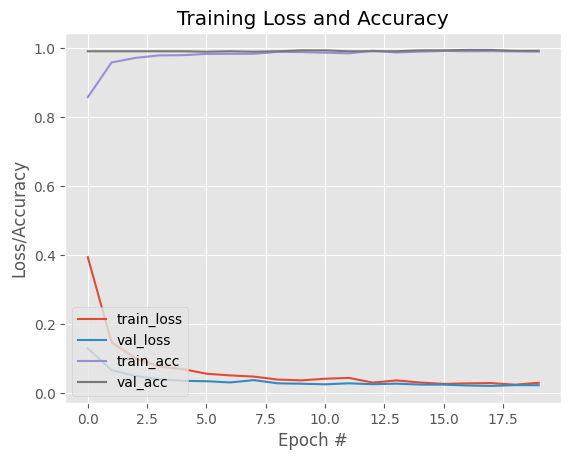

In [23]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")